In [15]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, forecast_by_week#, split_forecasts_by_week, plot_coverage, print_forecasts_by_week, forecast_by_week
from PythonFiles.Configuration import Configuration
from PythonFiles.PlottingFunctions import plot_forecast_entry, plot_coverage, print_forecasts_by_week
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gluonts.dataset.pandas import PandasDataset
from PythonFiles.rolling_dataset import generate_rolling_dataset, StepStrategy
config = Configuration()
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')
population_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/PopulationVector.csv", sep=',')
neighbourhood_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/AdjacentMatrix.csv", sep=',', index_col=0)

# WITHOUT FEATURES

In [2]:
locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
one_ts_df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")

#seperate the intervals for training and testing
train_set = one_ts_df.loc[(one_ts_df.index <= config.train_end_time) & (one_ts_df.index >= config.train_start_time), :]
test_set = one_ts_df.loc[(one_ts_df.index >= config.train_start_time) & (one_ts_df.index <= config.test_end_time), :]
start_time = min(test_set.index.difference(train_set.index))
end_time = max(test_set.index.difference(train_set.index))
#Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set, item_id='location', target="value", freq=config.parameters["freq"])
test_set = PandasDataset.from_long_dataframe(dataframe=test_set, item_id='location', target="value", freq=config.parameters["freq"])

test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy=StepStrategy(prediction_length=4,step_size=1),
                                    start_time=pd.Period(start_time, freq=config.parameters["freq"]),
                                    end_time=pd.Period(end_time, freq=config.parameters["freq"])
                                    )

100%|██████████| 50/50 [00:03<00:00, 16.13it/s, epoch=8/8, avg_epoch_loss=0.666]


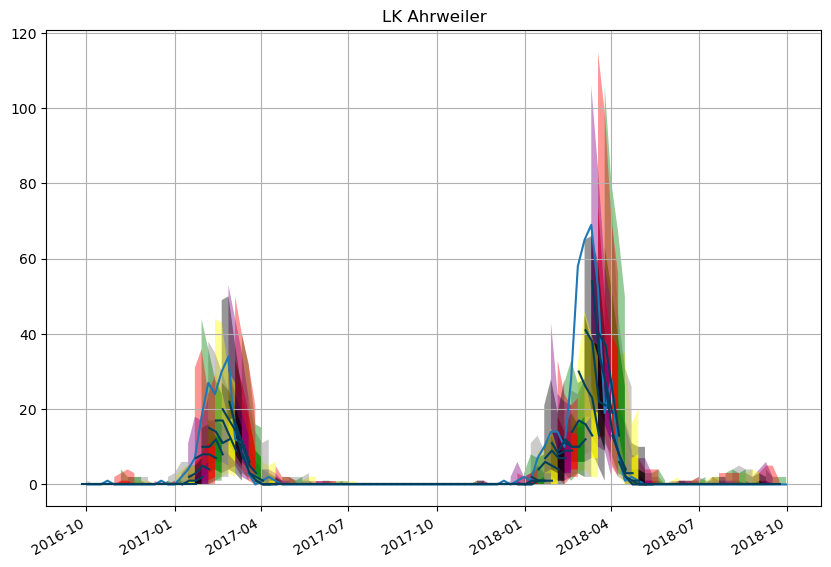

In [4]:
#train and evaluate the model
forecasts, tss = model(train_set, test_set, config.deeparestimator)
windows_per_location = int(len(test_set) / len(locations))
for location in locations[:1]:
    #plot the forecasts
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                            (one_ts_df.index <= config.test_end_time) &
                            (one_ts_df.index >= config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location'] == location) &
                           (one_ts_df.index <= config.test_end_time) &
                           (one_ts_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color = ['g', 'r', 'purple', 'black', 'yellow', 'grey'] * windows_per_location
    for k in range(0 + windows_per_location * locations.index(location),
                   windows_per_location + windows_per_location * locations.index(location)):
        ts_entry = tss[k]
        forecast_entry = forecasts[k]
        prediction_intervals = (50.0, 90.0)
        legend = ['train_set observations',"median prediction"] +\
                [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        plot_forecast_entry(config, forecast_entry, ax=plt, fillcolor=color[k % windows_per_location], prediction_intervals=prediction_intervals)
    plt.grid(which="both")
    plt.show()

100%|██████████| 50/50 [00:05<00:00,  8.63it/s, epoch=8/8, avg_epoch_loss=0.616]
Running evaluation: 411it [00:02, 157.61it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 167.43it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 178.35it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 172.27it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
 

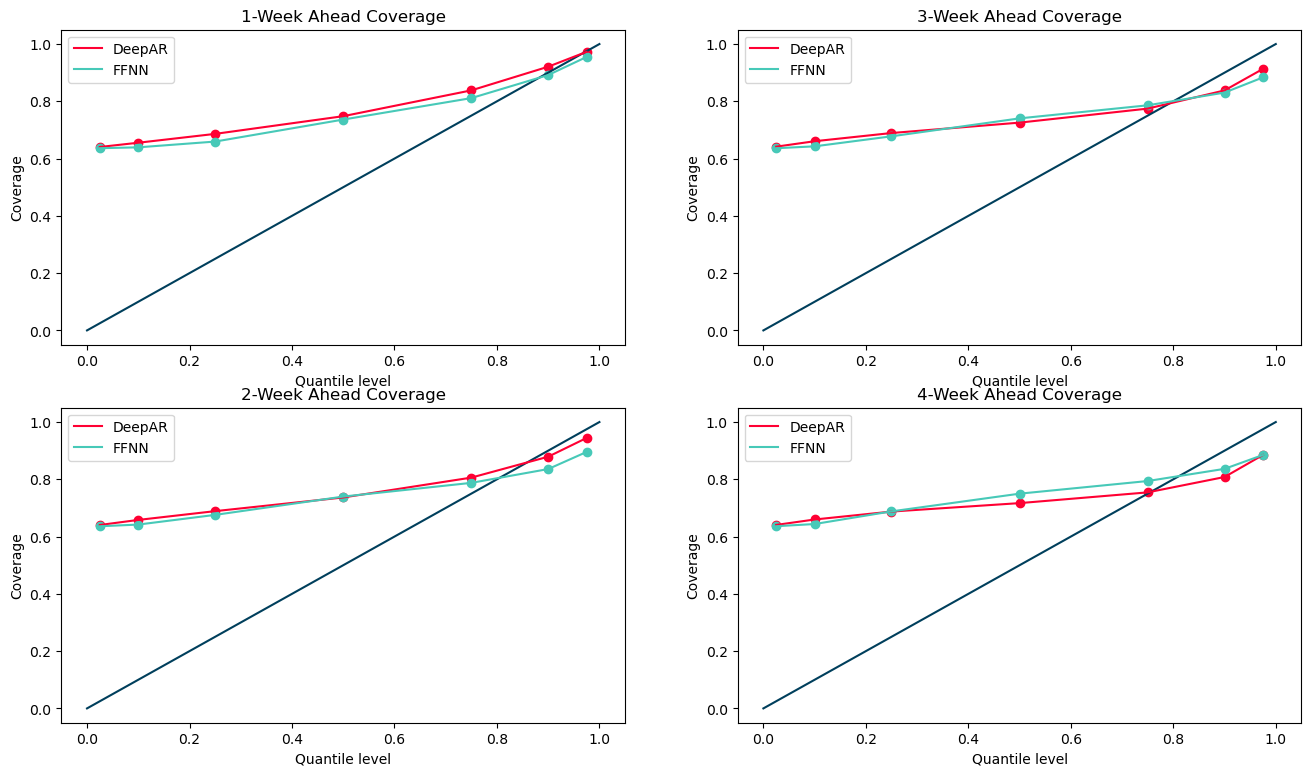

In [7]:
model_dict = {"DeepAR":config.deeparestimator, "FFNN":config.feedforwardestimator}
forecasts_dict, evaluator_df_dict = forecast_by_week(config, train_set, test_set, locations, model_dict)
plot_coverage(config, evaluator_df_dict)

In [8]:
#print(evaluator_df_dict["DeepAR"].loc[evaluator_df_dict["DeepAR"]["wQuantileLoss[0.75]"]>0])
for key in evaluator_df_dict.keys():
    print(key)
    ed = evaluator_df_dict[key].copy()
    print(ed.loc[ed.item_id.isin([item_id for item_id in ed.item_id if "aggregate" in item_id]),])

DeepAR
          item_id forecast_start          MSE  abs_error  abs_target_sum  \
0  aggregated {1}            NaT   483.194960   229021.0        470669.0   
0  aggregated {2}            NaT   803.920413   292729.0        470669.0   
0  aggregated {3}            NaT  1160.356460   355639.0        470669.0   
0  aggregated {4}            NaT  1444.597924   399751.0        470669.0   

   abs_target_mean  seasonal_error      MASE      MAPE     sMAPE  ...  \
0        11.685511        1.087644  4.989776  0.826548  1.041105  ...   
0        11.685511        1.087644  6.272406  0.981378  1.162555  ...   
0        11.685511        1.087644  7.554760  1.181544  1.323542  ...   
0        11.685511        1.087644  8.436150  1.346803  1.458329  ...   

   wQuantileLoss[0.5]  wQuantileLoss[0.75]  wQuantileLoss[0.9]  \
0            0.486586             0.455856            0.295285   
0            0.621942             0.668805            0.514339   
0            0.755603             0.893497      

In [9]:
for key in list(forecasts_dict.keys()):
        print(key)
        #print_forecasts_by_week(config, one_ts_df, forecasts_dict[key], locations[:1], [1,2,3,4], plot_begin_at_trainstart=False)
        print(evaluator_df_dict[key].loc[evaluator_df_dict[key].item_id.isin([f"{location}"+" {"+f"{i}" + "}" for location in locations[:1] for i in range(1,5)]),:])

DeepAR
            item_id         forecast_start         MSE  abs_error  \
0  LK Ahrweiler {1}  2016-10-17/2016-10-23   43.755819      257.0   
0  LK Ahrweiler {2}  2016-10-17/2016-10-23   69.390850      336.0   
0  LK Ahrweiler {3}  2016-10-17/2016-10-23  102.143542      386.0   
0  LK Ahrweiler {4}  2016-10-17/2016-10-23  125.829632      438.0   

   abs_target_sum  abs_target_mean  seasonal_error      MASE      MAPE  \
0           569.0         5.806122        0.668287  3.924137  0.680009   
0           569.0         5.806122        0.668287  5.130390  0.868362   
0           569.0         5.806122        0.668287  5.893840  0.990712   
0           569.0         5.806122        0.668287  6.687829  1.135959   

      sMAPE  ...  wQuantileLoss[0.5]  wQuantileLoss[0.75]  wQuantileLoss[0.9]  \
0  0.922819  ...                 NaN                  NaN                 NaN   
0  1.103646  ...                 NaN                  NaN                 NaN   
0  1.199291  ...                 

# WITH FEATURES

In [10]:
locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
one_ts_df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date','week']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")
for location in locations:
    one_ts_df.loc[one_ts_df.location == location, "population"] = int(population_df.loc[population_df.Location == location, "2011"].values[0])
    one_ts_df.loc[one_ts_df.location == location, locations] = neighbourhood_df.loc[neighbourhood_df.index==location,locations].values[0]

In [12]:
#seperate the intervals for training and testing
train_set = one_ts_df.loc[(one_ts_df.index <= config.train_end_time) & (one_ts_df.index >= config.train_start_time), :]
test_set = one_ts_df.loc[(one_ts_df.index >= config.train_start_time) & (one_ts_df.index <= config.test_end_time), :]

start_time = min(test_set.index.difference(train_set.index))
end_time = max(test_set.index.difference(train_set.index))
#Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set, item_id='location', target="value", freq=config.parameters["freq"],
                                              static_feature_columns=["population"]+locations, feat_dynamic_real=["week"])
test_set = PandasDataset.from_long_dataframe(dataframe=test_set, item_id='location', target="value", freq=config.parameters["freq"],
                                             static_feature_columns=["population"]+locations, feat_dynamic_real=["week"])

test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy=StepStrategy(prediction_length=4,step_size=1),
                                    start_time=pd.Period(start_time, config.parameters["freq"]),
                                    end_time=pd.Period(end_time, config.parameters["freq"])
                                    )

100%|██████████| 50/50 [00:07<00:00,  6.31it/s, epoch=8/8, avg_epoch_loss=0.745]
Running evaluation: 411it [00:02, 160.00it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 162.32it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 155.71it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 158.12it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
 

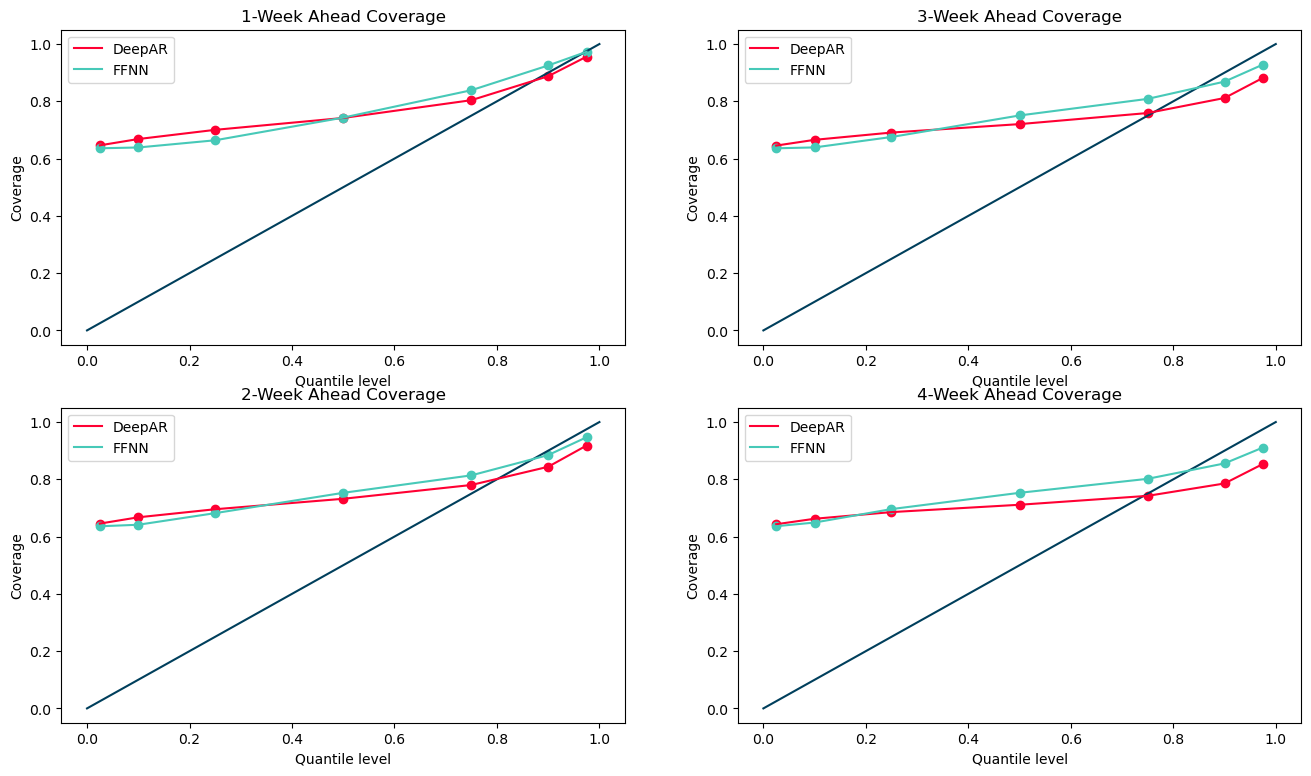

In [13]:
model_dict = {"DeepAR":config.deeparestimator, "FFNN":config.feedforwardestimator}
forecasts_dict, evaluator_df_dict = forecast_by_week(config, train_set, test_set, locations, model_dict)
plot_coverage(config, evaluator_df_dict)

DeepAR


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

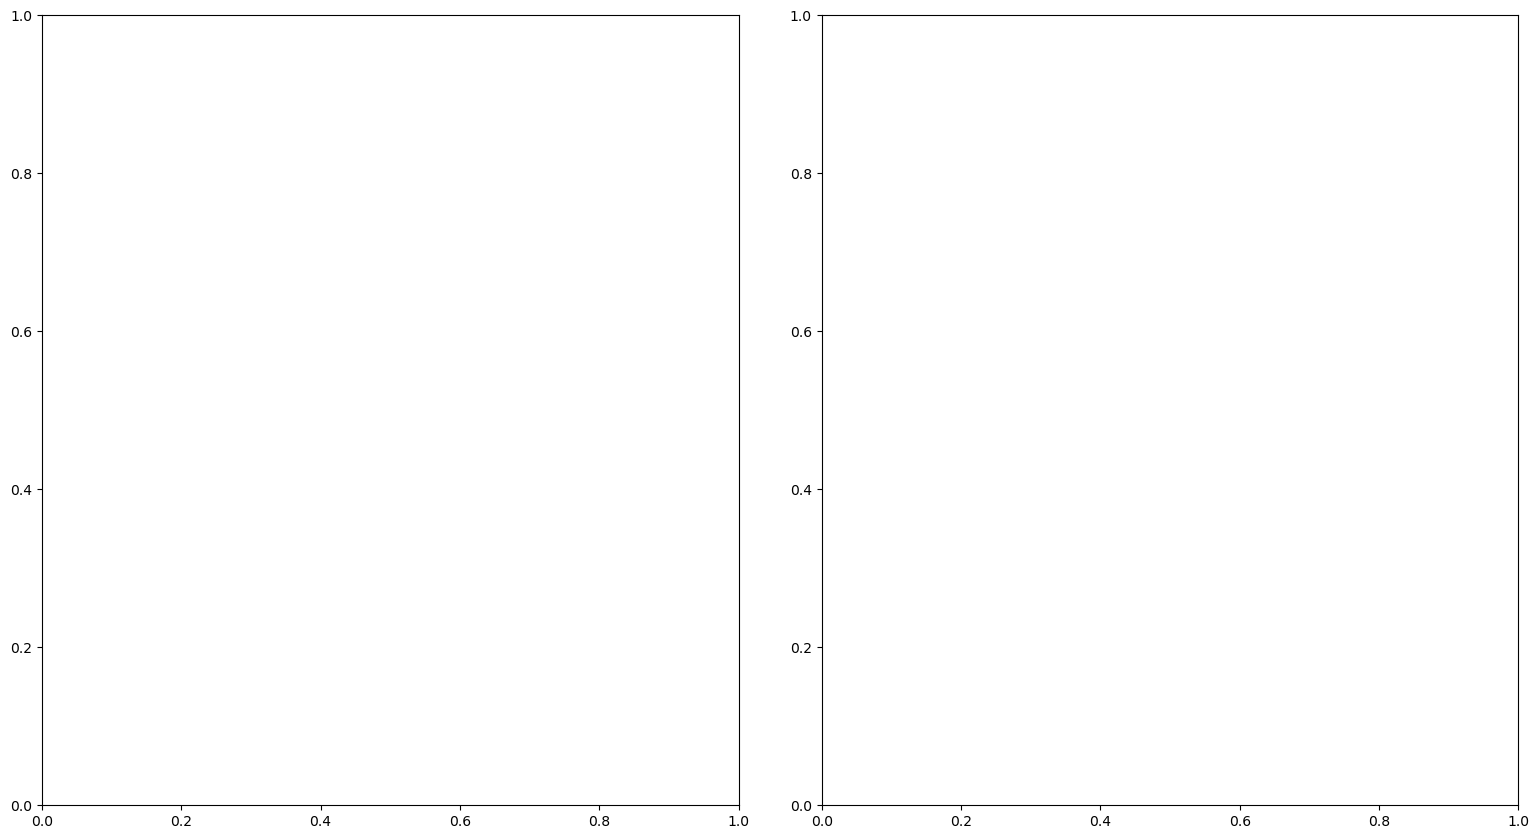

In [16]:
coverage_cols = ['Coverage[0.1]', 'Coverage[0.25]','Coverage[0.5]','Coverage[0.75]', 'Coverage[0.9]']
for key in list(forecasts_dict.keys()):
        print(key)
        print_forecasts_by_week(config, one_ts_df, forecasts_dict[key], locations[:1], [1,2,3,4], plot_begin_at_trainstart=False)
        print(evaluator_df_dict[key].loc[evaluator_df.item_id.isin([f"{location}"+" {"+f"{i}" + "}" for location in locations[:1] for i in range(1,5)]),['item_id']+coverage_cols])

In [ ]:
#print(evaluator_df_dict["DeepAR"].loc[evaluator_df_dict["DeepAR"]["wQuantileLoss[0.75]"]>0])
for key in evaluator_df_dict.keys():
    print(key)
    ed = evaluator_df_dict[key].copy()
    print(ed.loc[ed.item_id.isin([item_id for item_id in ed.item_id if "aggregate" in item_id]),])

In [ ]:
print([f"{location}"+f" {i}" for location in locations[:3] for i in range(1,5)])

In [ ]:
coverage_cols = ['Coverage[0.1]', 'Coverage[0.25]','Coverage[0.5]','Coverage[0.75]', 'Coverage[0.9]']
for location in locations[:5]:
    print(location)
    print(evaluator_df_dict["DeepAR"].loc[evaluator_df.item_id.isin([f"{location}"+" {1}", f"{location}"+" {2}", f"{location}"+" {3}", f"{location}"+" {4}"]),['item_id']+coverage_cols])

# Try out the full predictive horizon for training

In [ ]:
locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
one_ts_df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date','week']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")
for location in locations:
    one_ts_df.loc[one_ts_df.location == location, "population"] = int(population_df.loc[population_df.Location == location, "2011"].values[0])
    one_ts_df.loc[one_ts_df.location == location, locations] = neighbourhood_df.loc[neighbourhood_df.index==location,locations].values[0]

In [ ]:
#seperate the intervals for training and testing
train_set = one_ts_df.loc[(one_ts_df.index <= config.train_end_time), :]
test_set = one_ts_df.loc[(one_ts_df.index <= config.test_end_time), :]

start_time = min(test_set.index.difference(train_set.index))
end_time = max(test_set.index.difference(train_set.index))
#Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set, item_id='location', target="value", freq=config.parameters["freq"],
                                              static_feature_columns=["population"]+locations, feat_dynamic_real=["week"])
test_set = PandasDataset.from_long_dataframe(dataframe=test_set, item_id='location', target="value", freq=config.parameters["freq"],
                                             static_feature_columns=["population"]+locations, feat_dynamic_real=["week"])

test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy=StepStrategy(prediction_length=config.prediction_length,step_size=1),
                                    start_time=pd.Period(start_time,config.parameters["freq"]),
                                    end_time=pd.Period(end_time,config.parameters["freq"])
                                    )

In [ ]:
model_dict = {"DeepAR":config.deeparestimator, "FFNN":config.feedforwardestimator}
forecasts_dict, evaluator_df_dict = forecast_by_week(config, train_set, test_set, locations, model_dict)
plot_coverage(config, evaluator_df_dict)

In [ ]:
for key in evaluator_df_dict.keys():
    print(key)
    ed = evaluator_df_dict[key].copy()
    print(ed.loc[ed.item_id.isin([item_id for item_id in ed.item_id if "aggregate" in item_id]),])

In [ ]:
for key in list(forecasts_dict.keys()):
        print(key)
        print_forecasts_by_week(config, one_ts_df, forecasts_dict[key], locations[:1], [1,2,3,4], plot_begin_at_trainstart=False)